In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

In [3]:
# Create synthetic data for greenhouse gas emissions
def create_synthetic_data(start_date, end_date, num_locations=10):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    locations = [(np.random.uniform(-90, 90), np.random.uniform(-180, 180)) for _ in range(num_locations)]
    
    data = []
    for date in date_range:
        for lat, lon in locations:
            # Create simple models for CO2, CO, and CH4 concentrations
            base_co2 = 400  # base CO2 level in ppm
            base_co = 0.1  # base CO level in ppm
            base_ch4 = 1.8  # base CH4 level in ppm
            
            latitude_effect = (90 - abs(lat)) / 2  # higher near equator
            seasonal_effect = 5 * np.sin(2 * np.pi * date.dayofyear / 365)  # seasonal variation
            
            co2_concentration = base_co2 + latitude_effect + seasonal_effect + np.random.normal(0, 2)
            co_concentration = base_co + latitude_effect/10 + seasonal_effect/10 + np.random.normal(0, 0.01)
            ch4_concentration = base_ch4 + latitude_effect/20 + seasonal_effect/20 + np.random.normal(0, 0.05)
            
            data.append([date, lat, lon, co2_concentration, co_concentration, ch4_concentration])
    
    return pd.DataFrame(data, columns=['Date', 'Latitude', 'Longitude', 'CO2_Concentration', 'CO_Concentration', 'CH4_Concentration'])

In [4]:
# Create the synthetic data
start_date = datetime(2023, 9, 9)
end_date = datetime(2024, 11, 8)  # Extended to cover 60 days from current date
df = create_synthetic_data(start_date, end_date)

In [6]:
# Save the data to a CSV file
csv_filename = 'synthetic_greenhouse_gas_data.csv'
df.to_csv(csv_filename, index=False)
print(f"CSV file '{csv_filename}' has been created.")

CSV file 'synthetic_greenhouse_gas_data.csv' has been created.


In [7]:
# Display the first few rows of the data
print(df.head())

        Date   Latitude  Longitude  CO2_Concentration  CO_Concentration  \
0 2023-09-09  42.162634  39.403913         420.036300          2.019712   
1 2023-09-09  -0.320931  75.536749         442.603386          4.117530   
2 2023-09-09  83.680515  15.506585         396.913417         -0.070356   
3 2023-09-09 -50.884990  64.446657         415.232143          1.566997   
4 2023-09-09 -87.661596   8.411304         396.071152         -0.259826   

   CH4_Concentration  
0           2.815376  
1           3.711159  
2           1.695502  
3           2.518199  
4           1.699864  


In [8]:
# Check for missing values
print(df.isnull().sum())

Date                 0
Latitude             0
Longitude            0
CO2_Concentration    0
CO_Concentration     0
CH4_Concentration    0
dtype: int64


In [9]:
# Basic statistical summary of the data
print(df.describe())

                      Date     Latitude    Longitude  CO2_Concentration  \
count                 4270  4270.000000  4270.000000        4270.000000   
mean   2024-04-09 00:00:00    15.015799    28.383956         420.812907   
min    2023-09-09 00:00:00   -87.661596  -143.027388         391.040640   
25%    2023-12-24 00:00:00   -21.675753     8.411304         406.477146   
50%    2024-04-09 00:00:00    31.634721    51.925285         423.710504   
75%    2024-07-25 00:00:00    42.162634    75.536749         430.979242   
max    2024-11-08 00:00:00    84.690611   156.386089         455.058609   
std                    NaN    52.736561    90.286203          14.594302   

       CO_Concentration  CH4_Concentration  
count       4270.000000        4270.000000  
mean           2.175132           2.838102  
min           -0.301347           1.479762  
25%            0.712897           2.108242  
50%            2.508792           2.997047  
75%            3.164403           3.336584  
max      

In [10]:
# Convert date to numerical feature
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear

In [11]:
# Prepare the features (X) and target variables (y)
X = df[['Latitude', 'Longitude', 'DayOfYear']]
y_co2 = df['CO2_Concentration']
y_co = df['CO_Concentration']
y_ch4 = df['CH4_Concentration']

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_co2_train, y_co2_test, y_co_train, y_co_test, y_ch4_train, y_ch4_test = train_test_split(
    X, y_co2, y_co, y_ch4, test_size=0.2, random_state=42)

In [13]:
# Create and train the models
model_co2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_co = RandomForestRegressor(n_estimators=100, random_state=42)
model_ch4 = RandomForestRegressor(n_estimators=100, random_state=42)

model_co2.fit(X_train, y_co2_train)
model_co.fit(X_train, y_co_train)
model_ch4.fit(X_train, y_ch4_train)

RandomForestRegressor(random_state=42)

In [14]:
# Make predictions on the test set
y_co2_pred = model_co2.predict(X_test)
y_co_pred = model_co.predict(X_test)
y_ch4_pred = model_ch4.predict(X_test)

In [15]:
# Evaluate the models
for gas, y_test, y_pred in [('CO2', y_co2_test, y_co2_pred), 
                            ('CO', y_co_test, y_co_pred), 
                            ('CH4', y_ch4_test, y_ch4_pred)]:
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{gas} - Mean Squared Error: {mse}")
    print(f"{gas} - R-squared Score: {r2}")

CO2 - Mean Squared Error: 5.873198623928213
CO2 - R-squared Score: 0.9717027491451757
CO - Mean Squared Error: 0.000159242589975763
CO - R-squared Score: 0.99992176128771
CH4 - Mean Squared Error: 0.0036460478752216685
CH4 - R-squared Score: 0.9929166240103874


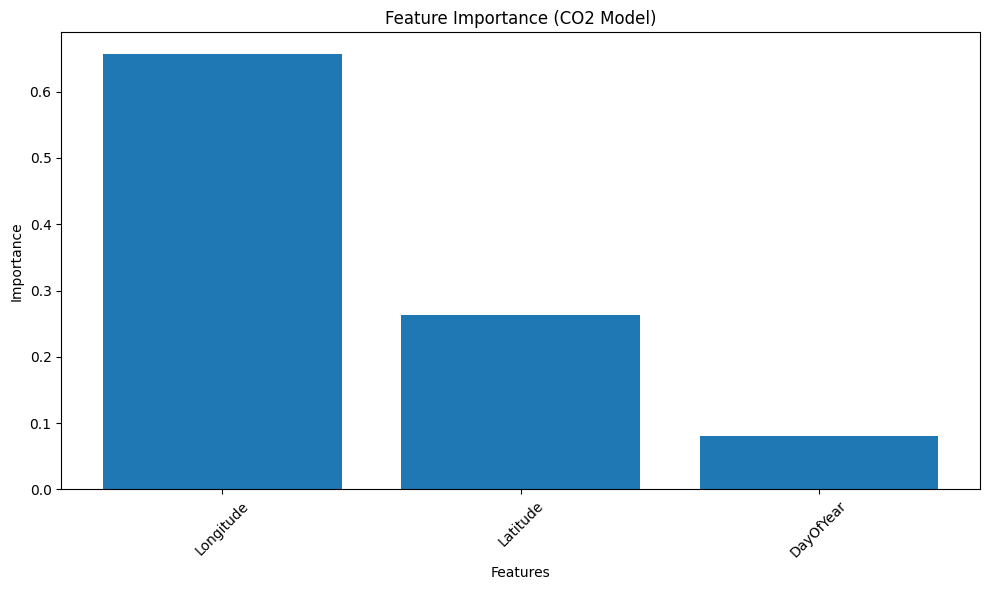

In [16]:
# Feature importance (using CO2 model as an example)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model_co2.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (CO2 Model)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

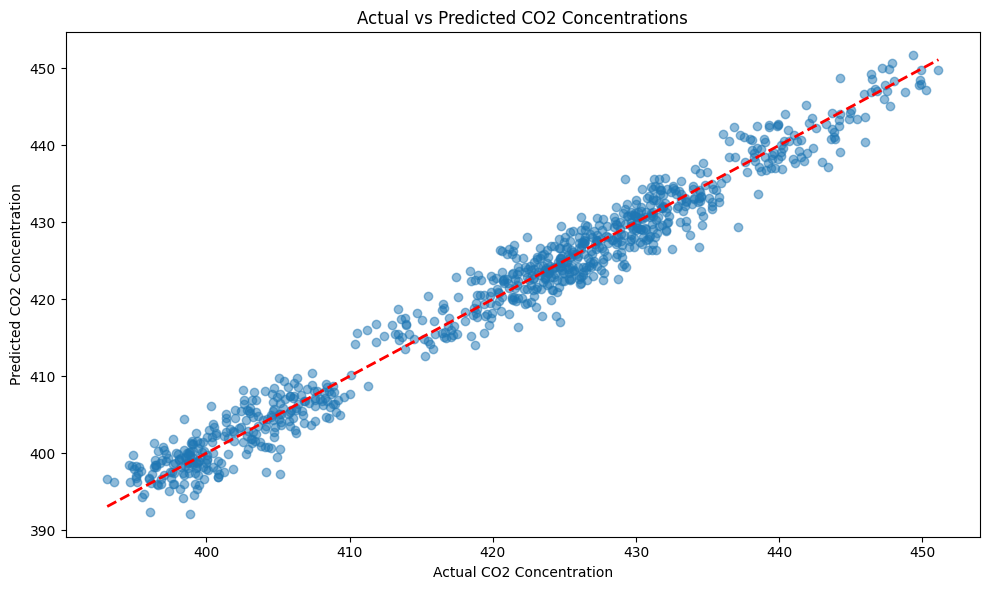

In [17]:
# Visualize predictions vs actual values (CO2 as an example)
plt.figure(figsize=(10, 6))
plt.scatter(y_co2_test, y_co2_pred, alpha=0.5)
plt.plot([y_co2_test.min(), y_co2_test.max()], [y_co2_test.min(), y_co2_test.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Concentration')
plt.ylabel('Predicted CO2 Concentration')
plt.title('Actual vs Predicted CO2 Concentrations')
plt.tight_layout()
plt.show()

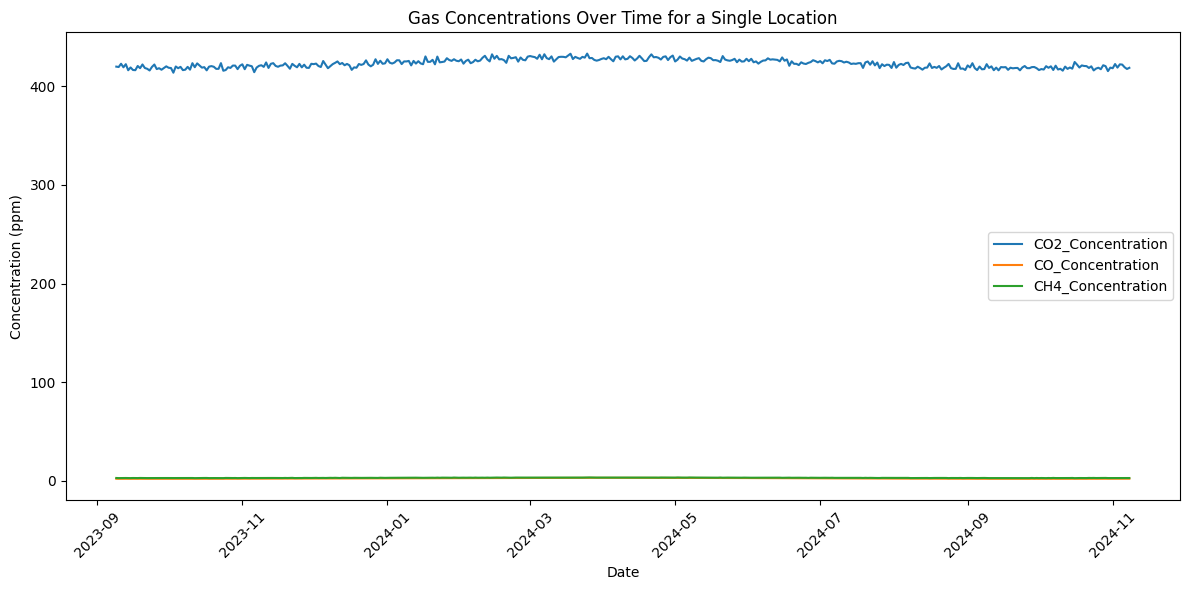

In [18]:
# Visualize gas concentrations over time for a single location
single_location = df[df['Latitude'] == df['Latitude'].iloc[0]]
plt.figure(figsize=(12, 6))
for gas in ['CO2_Concentration', 'CO_Concentration', 'CH4_Concentration']:
    plt.plot(single_location['Date'], single_location[gas], label=gas)
plt.title('Gas Concentrations Over Time for a Single Location')
plt.xlabel('Date')
plt.ylabel('Concentration (ppm)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Save the models
import joblib
joblib.dump(model_co2, 'greenhouse_gas_model_co2.joblib')
joblib.dump(model_co, 'greenhouse_gas_model_co.joblib')
joblib.dump(model_ch4, 'greenhouse_gas_model_ch4.joblib')
print("Models saved as 'greenhouse_gas_model_co2.joblib', 'greenhouse_gas_model_co.joblib', and 'greenhouse_gas_model_ch4.joblib'")

Models saved as 'greenhouse_gas_model_co2.joblib', 'greenhouse_gas_model_co.joblib', and 'greenhouse_gas_model_ch4.joblib'
